# User Experience Analysis

## Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from df_selector import *
from df_visualizer import *
from df_outlier_handler import OutlierHandler

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
pd.set_option('display.max_columns', 100)

## Reading Data

In [3]:
df = pd.read_csv("../data/clean_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146887 entries, 0 to 146886
Data columns (total 55 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Unnamed: 0                        146887 non-null  int64  
 1   Bearer Id                         146887 non-null  int64  
 2   Start                             146887 non-null  object 
 3   Start Offset (ms)                 146887 non-null  float64
 4   End                               146887 non-null  object 
 5   End Offset (ms)                   146887 non-null  float64
 6   IMSI                              146887 non-null  int64  
 7   MSISDN/Number                     146887 non-null  int64  
 8   IMEI                              146887 non-null  int64  
 9   Last Location Name                146887 non-null  object 
 10  Avg RTT DL (ms)                   146887 non-null  float64
 11  Avg RTT UL (ms)                   146887 non-null  f

## User Experience Metrics

In [94]:
user_experience_df = df[[
    'MSISDN/Number',
    'Avg RTT DL (ms)',
    'Avg RTT UL (ms)',
    'Avg Bearer TP DL (kbps)',
    'Avg Bearer TP UL (kbps)',
    'TCP DL Retrans. Vol (Bytes)',
    'TCP UL Retrans. Vol (Bytes)',
    'Handset Type']]

In [95]:
# caluclate the totals
user_experience_df['Total Avg RTT (ms)'] = user_experience_df['Avg RTT DL (ms)'] + user_experience_df['Avg RTT UL (ms)']
user_experience_df['Total Avg Bearer TP (kbps)'] = user_experience_df['Avg Bearer TP DL (kbps)'] + user_experience_df['Avg Bearer TP UL (kbps)']
user_experience_df['Total TCP Retrans. Vol (Bytes)'] = user_experience_df['TCP DL Retrans. Vol (Bytes)'] + user_experience_df['TCP UL Retrans. Vol (Bytes)']
user_experience_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146887 entries, 0 to 146886
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   MSISDN/Number                   146887 non-null  int64  
 1   Avg RTT DL (ms)                 146887 non-null  float64
 2   Avg RTT UL (ms)                 146887 non-null  float64
 3   Avg Bearer TP DL (kbps)         146887 non-null  float64
 4   Avg Bearer TP UL (kbps)         146887 non-null  float64
 5   TCP DL Retrans. Vol (Bytes)     146887 non-null  float64
 6   TCP UL Retrans. Vol (Bytes)     146887 non-null  float64
 7   Handset Type                    146887 non-null  object 
 8   Total Avg RTT (ms)              146887 non-null  float64
 9   Total Avg Bearer TP (kbps)      146887 non-null  float64
 10  Total TCP Retrans. Vol (Bytes)  146887 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 12.3+ MB


In [96]:
user_experience_df.head()

MSISDN/Number  Avg RTT DL (ms)  Avg RTT UL (ms)  Avg Bearer TP DL (kbps)  \
0    33664962239             42.0              5.0                     23.0   
1    33681854413             65.0              5.0                     16.0   
2    33760627129             65.0              5.0                      6.0   
3    33750343200             65.0              5.0                     44.0   
4    33699795932             65.0              5.0                      6.0   

   Avg Bearer TP UL (kbps)  TCP DL Retrans. Vol (Bytes)  \
0                     44.0                      19520.0   
1                     26.0                      19520.0   
2                      9.0                      19520.0   
3                     44.0                      19520.0   
4                      9.0                      19520.0   

   TCP UL Retrans. Vol (Bytes)                 Handset Type  \
0                       7230.0   Samsung Galaxy A5 Sm-A520F   
1                       7230.0  Samsung Galaxy J5 (Sm-J530)   
2                       7230.0     Samsung Galaxy A8 (2018)   
3                       7230.0                      unknown   
4                       7230.0             Samsung Sm-G390F   

   Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  \
0                47.0                        67.0   
1                70.0                        42.0   
2                70.0                        15.0   
3                70.0                        88.0   
4                70.0                        15.0   

   Total TCP Retrans. Vol (Bytes)  
0                         26750.0  
1                         26750.0  
2                         26750.0  
3                         26750.0  
4                         26750.0

In [97]:
# select the necessary columns
user_experience_df = user_experience_df[['MSISDN/Number', 'Handset Type', 'Total Avg RTT (ms)',
    'Total Avg Bearer TP (kbps)', 'Total TCP Retrans. Vol (Bytes)']]
user_experience_df.head()

MSISDN/Number                 Handset Type  Total Avg RTT (ms)  \
0    33664962239   Samsung Galaxy A5 Sm-A520F                47.0   
1    33681854413  Samsung Galaxy J5 (Sm-J530)                70.0   
2    33760627129     Samsung Galaxy A8 (2018)                70.0   
3    33750343200                      unknown                70.0   
4    33699795932             Samsung Sm-G390F                70.0   

   Total Avg Bearer TP (kbps)  Total TCP Retrans. Vol (Bytes)  
0                        67.0                         26750.0  
1                        42.0                         26750.0  
2                        15.0                         26750.0  
3                        88.0                         26750.0  
4                        15.0                         26750.0

In [98]:
# aggregating user experience metrics per user
user_experience_df1 = user_experience_df.groupby(
    'MSISDN/Number').agg({
        'Total Avg RTT (ms)': 'sum',
        'Total Avg Bearer TP (kbps)': 'sum',
        'Total TCP Retrans. Vol (Bytes)': 'sum',
        'Handset Type': [lambda x: x.mode()[0]]})
user_experience_df1.head()

Total Avg RTT (ms) Total Avg Bearer TP (kbps)  \
                             sum                        sum   
MSISDN/Number                                                 
33601001722                 46.0                       76.0   
33601001754                 31.0                       99.0   
33601002511                 59.0                       97.0   
33601007832                 84.0                      248.0   
33601008617                119.0                    43204.5   

              Total TCP Retrans. Vol (Bytes)                    Handset Type  
                                         sum                        <lambda>  
MSISDN/Number                                                                 
33601001722                        2895381.0  Huawei P20 Lite Huawei Nova 3E  
33601001754                        7685845.5          Apple iPhone 7 (A1778)  
33601002511                        4150403.0                         unknown  
33601007832                           2396.0         Apple iPhone 5S (A1457)  
33601008617                        8047274.5         Apple iPhone Se (A1723)

In [99]:
user_experience_df = pd.DataFrame(columns=[
    "Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)",
    "Handset Type"])

user_experience_df["Total Avg RTT (ms)"] = user_experience_df1["Total Avg RTT (ms)"]['sum']
user_experience_df["Total Avg Bearer TP (kbps)"] = user_experience_df1["Total Avg Bearer TP (kbps)"]['sum']
user_experience_df["Total TCP Retrans. Vol (Bytes)"] = user_experience_df1["Total TCP Retrans. Vol (Bytes)"]['sum']
user_experience_df["Handset Type"] = user_experience_df1["Handset Type"]['<lambda>']
user_experience_df.head()

Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  \
MSISDN/Number                                                   
33601001722                  46.0                        76.0   
33601001754                  31.0                        99.0   
33601002511                  59.0                        97.0   
33601007832                  84.0                       248.0   
33601008617                 119.0                     43204.5   

               Total TCP Retrans. Vol (Bytes)                    Handset Type  
MSISDN/Number                                                                  
33601001722                         2895381.0  Huawei P20 Lite Huawei Nova 3E  
33601001754                         7685845.5          Apple iPhone 7 (A1778)  
33601002511                         4150403.0                         unknown  
33601007832                            2396.0         Apple iPhone 5S (A1457)  
33601008617                         8047274.5         Apple iPhone Se (A1723)

## Top 10 values of the experience metrics

In [100]:
# top 10 rtt values in the dataset

rtt = user_experience_df.sort_values('Total Avg RTT (ms)', ascending=False)
top_10 = rtt.head(10)['Total Avg RTT (ms)']
bottom_10 = rtt.tail(10)['Total Avg RTT (ms)']
most_10 = user_experience_df['Total Avg RTT (ms)'].value_counts().head(10)

In [101]:
plotly_multi_hist([top_10, bottom_10, most_10], 1, 3,
    "RTT values in the dataset", ['Top 10', 'Bottom 10', 'Most 10'])

In [102]:
# top 10 tp values in the dataset

tp = user_experience_df.sort_values('Total Avg Bearer TP (kbps)', ascending=False)
top_10 = tp.head(10)['Total Avg Bearer TP (kbps)']
bottom_10 = tp.tail(10)['Total Avg Bearer TP (kbps)']
most_10 = user_experience_df['Total Avg Bearer TP (kbps)'].value_counts().head(10)

In [103]:
plotly_multi_hist([top_10, bottom_10, most_10], 1, 3,
    "TP values in the dataset", ['Top 10', 'Bottom 10', 'Most 10'])

In [104]:
# top 10 tcp values in the dataset

tcp = user_experience_df.sort_values('Total TCP Retrans. Vol (Bytes)', ascending=False)
top_10 = tcp.head(10)['Total TCP Retrans. Vol (Bytes)']
bottom_10 = tcp.tail(10)['Total TCP Retrans. Vol (Bytes)']
most_10 = user_experience_df['Total TCP Retrans. Vol (Bytes)'].value_counts().head(10)

In [105]:
plotly_multi_hist([top_10, bottom_10, most_10], 1, 3,
    "TCP values in the dataset", ['Top 10', 'Bottom 10', 'Most 10'])

## Average values of experience metrics per handset type

In [106]:
handset_type_df = user_experience_df.groupby('Handset Type').mean()
handset_type_df.head()

Total Avg RTT (ms)  \
Handset Type                                            
A-Link Telecom I. Cubot A5                       42.0   
A-Link Telecom I. Cubot Note Plus               129.0   
A-Link Telecom I. Cubot Note S                  125.0   
A-Link Telecom I. Cubot Nova                     44.0   
A-Link Telecom I. Cubot Power                    43.0   

                                   Total Avg Bearer TP (kbps)  \
Handset Type                                                    
A-Link Telecom I. Cubot A5                            23510.0   
A-Link Telecom I. Cubot Note Plus                      6699.0   
A-Link Telecom I. Cubot Note S                         8937.0   
A-Link Telecom I. Cubot Nova                          50545.5   
A-Link Telecom I. Cubot Power                         50337.5   

                                   Total TCP Retrans. Vol (Bytes)  
Handset Type                                                       
A-Link Telecom I. Cubot A5                              7673075.5  
A-Link Telecom I. Cubot Note Plus                        616213.0  
A-Link Telecom I. Cubot Note S                          7725274.5  
A-Link Telecom I. Cubot Nova                             137170.0  
A-Link Telecom I. Cubot Power                              8041.0

In [107]:
# sorting per tp
tp = handset_type_df.sort_values(
    'Total Avg Bearer TP (kbps)', ascending=False)
tp.head()

Total Avg RTT (ms)  \
Handset Type                                             
Huawei Par-Lx9                              213.500000   
Spa Condor Elect. Allure M2                  90.000000   
Asustek Wireless-Ac1200 Lte Router          207.000000   
Lg-H860                                      90.000000   
Huawei B618S-22D                            262.333333   

                                    Total Avg Bearer TP (kbps)  \
Handset Type                                                     
Huawei Par-Lx9                                        127454.0   
Spa Condor Elect. Allure M2                           102025.0   
Asustek Wireless-Ac1200 Lte Router                     79401.0   
Lg-H860                                                79107.5   
Huawei B618S-22D                                       78003.5   

                                    Total TCP Retrans. Vol (Bytes)  
Handset Type                                                        
Huawei Par-Lx9                                         2896635.000  
Spa Condor Elect. Allure M2                              89016.000  
Asustek Wireless-Ac1200 Lte Router                     1309069.125  
Lg-H860                                                7691148.500  
Huawei B618S-22D                                       8259451.750

In [108]:
# sorting per tcp
tcp = handset_type_df.sort_values(
    'Total TCP Retrans. Vol (Bytes)', ascending=False)
tcp.head()

Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  \
Handset Type                                                              
Sierra Wireless Usb305               245.00                     31440.0   
Huawei Me909S-120                    208.00                      1548.5   
Sfr Star Trail 5 By Sfr              265.00                      9718.0   
Huawei B715S-23C                     119.25                     64984.9   
Wistron Wnc D18Qx                    217.00                      3446.0   

                         Total TCP Retrans. Vol (Bytes)  
Handset Type                                             
Sierra Wireless Usb305                     1.564926e+07  
Huawei Me909S-120                          1.473096e+07  
Sfr Star Trail 5 By Sfr                    9.822624e+06  
Huawei B715S-23C                           8.784473e+06  
Wistron Wnc D18Qx                          8.707187e+06

## Outliers

In [109]:
user_experience_df = user_experience_df[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]]

In [110]:
outlier_handler = OutlierHandler(user_experience_df)

<AxesSubplot:>

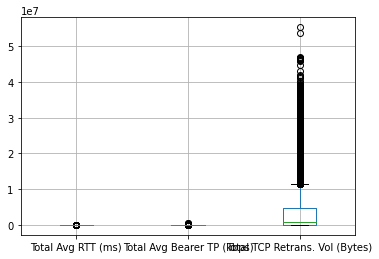

In [111]:
user_experience_df.boxplot()

In [112]:
outlier_handler.getOverview(["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"])

Name of columns        Total Avg Bearer TP (kbps) Total Avg RTT (ms)  \
Min                                           0.0                0.0   
Q1                                           97.0               39.0   
Median                                      302.0               64.0   
Q3                                      25398.625              118.0   
Max                                      445187.0             1270.0   
IQR                                     25301.625               79.0   
Lower fence                           -37855.4375              -79.5   
Upper fence                            63351.0625              236.5   
Skew                                     3.269035           3.432164   
Number_of_outliers                           4950               4575   
Percentage_of_outliers                       3.3%              3.05%   

Name of columns        Total TCP Retrans. Vol (Bytes)  
Min                                              51.0  
Q1                                           83894.25  
Median                                       700892.0  
Q3                                         4661146.25  
Max                                        55343102.0  
IQR                                         4577252.0  
Lower fence                               -6781983.75  
Upper fence                               11527024.25  
Skew                                         2.764108  
Number_of_outliers                               3626  
Percentage_of_outliers                          2.42%

In [113]:
outlier_handler.replace_outliers_with_fences(["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"])

In [114]:
outlier_handler.getOverview(["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"])

Name of columns        Total Avg RTT (ms) Total Avg Bearer TP (kbps)  \
Min                                   0.0                        0.0   
Q1                                   39.0                       97.0   
Median                               64.0                      302.0   
Q3                                  118.0                  25398.625   
Max                                 236.5                 63351.0625   
IQR                                  79.0                  25301.625   
Lower fence                         -79.5                -37855.4375   
Upper fence                         236.5                 63351.0625   
Skew                             1.208047                   1.215236   
Number_of_outliers                      0                          0   
Percentage_of_outliers               0.0%                       0.0%   

Name of columns        Total TCP Retrans. Vol (Bytes)  
Min                                              51.0  
Q1                                           83894.25  
Median                                       700892.0  
Q3                                         4661146.25  
Max                                       11527024.25  
IQR                                         4577252.0  
Lower fence                               -6781983.75  
Upper fence                               11527024.25  
Skew                                         1.166526  
Number_of_outliers                                  0  
Percentage_of_outliers                           0.0%

<AxesSubplot:>

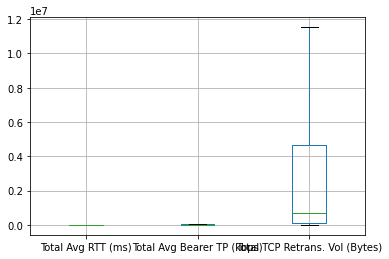

In [115]:
user_experience_df.boxplot()

## K-means Clustering

In [117]:
# scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(user_experience_df)
scaled_data

array([[-0.6592221 , -0.67835113,  0.07974981],
       [-0.93025698, -0.67723988,  1.48764748],
       [-0.4243252 , -0.67733651,  0.44859557],
       ...,
       [-0.55080815, -0.18123297, -0.70710815],
       [-0.76763605, -0.67641851, -0.6983095 ],
       [-0.40625621, -0.6804287 , -0.73574801]])

In [119]:
normalized_data = normalize(scaled_data)
normalized_data

array([[-0.69445913, -0.71461066,  0.08401263],
       [-0.49462677, -0.36009509,  0.79099677],
       [-0.46295619, -0.7390019 ,  0.48943616],
       ...,
       [-0.60233164, -0.1981858 , -0.77325221],
       [-0.61969779, -0.54605963, -0.5637318 ],
       [-0.37568797, -0.62923071, -0.68038758]])

In [120]:
kmeans = KMeans(n_clusters=3, random_state=1).fit(normalized_data)
kmeans.labels_

array([1, 0, 0, ..., 1, 1, 1], dtype=int32)

In [121]:
user_experience_df.insert(0, 'cluster', kmeans.labels_)
user_experience_df

cluster  Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  \
MSISDN/Number                                                              
33601001722            1                46.0                        76.0   
33601001754            0                31.0                        99.0   
33601002511            0                59.0                        97.0   
33601007832            1                84.0                       248.0   
33601008617            2               119.0                     43204.5   
...                  ...                 ...                         ...   
33789967113            1                53.0                        67.0   
33789980299            2               109.0                     52859.0   
33789996170            1                52.0                     10365.0   
33789997247            1                40.0                       116.0   
337000037000919        1                60.0                        33.0   

                 Total TCP Retrans. Vol (Bytes)  
MSISDN/Number                                    
33601001722                          2895381.00  
33601001754                          7685845.50  
33601002511                          4150403.00  
33601007832                             2396.00  
33601008617                          8047274.50  
...                                         ...  
33789967113                            56578.00  
33789980299                          7834724.25  
33789996170                           218045.00  
33789997247                           247983.00  
337000037000919                       120596.00  

[105716 rows x 4 columns]

In [122]:
user_experience_df['cluster'].value_counts()

1    53908
2    33122
0    18686
Name: cluster, dtype: int64

In [128]:
fig = px.scatter(user_experience_df, x='Total TCP Retrans. Vol (Bytes)', y='Total Avg Bearer TP (kbps)',
                 color='cluster', size='Total Avg RTT (ms)')
fig.show()

In [129]:
cluster0 = user_experience_df[user_experience_df["cluster"]==0]
cluster0[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]].describe()

Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  \
count        18686.000000                18686.000000   
mean            75.031842                 3004.934095   
std             46.764316                 7019.497972   
min              0.000000                    0.000000   
25%             38.000000                   91.000000   
50%             61.000000                  125.000000   
75%            106.500000                  654.000000   
max            236.500000                52878.000000   

       Total TCP Retrans. Vol (Bytes)  
count                    1.868600e+04  
mean                     7.096333e+06  
std                      1.922786e+06  
min                      2.364407e+06  
25%                      5.940406e+06  
50%                      7.687372e+06  
75%                      7.824628e+06  
max                      1.152702e+07

In [130]:
cluster1 = user_experience_df[user_experience_df["cluster"]==1]
cluster1[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]].describe()

Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  \
count        53908.000000                53908.000000   
mean            57.582882                 2056.379025   
std             32.297199                 4977.277115   
min              0.000000                    0.000000   
25%             33.000000                   85.000000   
50%             48.000000                  111.000000   
75%             71.500000                  530.000000   
max            157.000000                32123.000000   

       Total TCP Retrans. Vol (Bytes)  
count                    5.390800e+04  
mean                     4.634245e+05  
std                      7.151232e+05  
min                      5.100000e+01  
25%                      2.489400e+04  
50%                      1.304890e+05  
75%                      5.452235e+05  
max                      3.637507e+06

In [131]:
cluster2 = user_experience_df[user_experience_df["cluster"]==2]
cluster2[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]].describe()

Total Avg RTT (ms)  Total Avg Bearer TP (kbps)  \
count        33122.000000                33122.000000   
mean           127.214978                40012.225949   
std             61.670431                17949.609158   
min             19.000000                    2.000000   
25%             76.625000                27168.250000   
50%            121.000000                44214.750000   
75%            165.000000                52765.000000   
max            236.500000                63351.062500   

       Total TCP Retrans. Vol (Bytes)  
count                    3.312200e+04  
mean                     3.617453e+06  
std                      3.763741e+06  
min                      9.700000e+01  
25%                      4.236432e+05  
50%                      1.987370e+06  
75%                      7.330257e+06  
max                      1.152702e+07

## Saving Data

In [ ]:
# save the dataframe
user_experience_df.to_csv('../data/user_experience_data.csv')

In [ ]:
# save the clustering model
with open("../models/user_experience.pkl", "wb") as f:
    pickle.dump(kmeans, f)